In [95]:
#!pip install fasttext
!rm -rf ReST/
!git clone https://github.com/alessandrocuda/SaRaH
!wget http://www.italianlp.it/twitter128.bin

Cloning into 'SaRaH'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 419 (delta 4), reused 23 (delta 2), pack-reused 394
Receiving objects: 100% (419/419), 143.21 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Checking out files: 100% (60/60), done.
--2021-02-11 17:41:11--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  27.4MB/s    in 25s     

2021-02-11 17:41:37 (23.3 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [1]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
#root_project = "/content/ReSt/"
root_project = "/Users/Alessandro/Dev/repos/ReSt/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb

%load_ext autoreload
%autoreload 2

In [2]:
print(tf.__version__)

2.4.1


# Path

In [3]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
#w2v_path                   = "/content/twitter128.bin"
w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

# Embedding

In [4]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


In [5]:
# test embedding
print(index_to_key[0])
print(index_to_key[100])
print(key_to_index[index_to_key[0]])
print(key_to_index[index_to_key[100]])
emb1 = w2v[index_to_key[100]]

inp = Input((2,))
out = Embedding(vocab_size, WORD_EMB_SIZE, input_length=2, weights=[embedding_matrix], trainable=False)(inp)
model = Model(inp, out)
emb2 = model.predict(np.array([0,100]).reshape((1, 2)))
np.array_equal(emb1, emb2[0][1])

<UNK>
"faccio
0
100


True

# DATA

In [6]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [7]:
def load_data(dataset_dict, w2v, key_to_index, max_text_len):
    #TODO: deve ritornare anche tutto il resto, extra, lemma, stem, ...
    senteces = dataset_dict["tokens"]
    X = dataset_dict["tokens"]
    X = set_unkmark_token(X, w2v)
    X = get_int_seq(X, key_to_index)
    X = pad_sequences(X, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
    y = np.array(dataset_dict["stereotype"])
    return X, y

In [8]:
#load dev/test
MAX_TEXT_LEN = 65

X, y = load_data(dataset_dev, w2v, key_to_index, MAX_TEXT_LEN)
X_test, y_test = load_data(dataset_test_tweets, w2v, key_to_index, MAX_TEXT_LEN)

In [9]:
print("Check:")
print(dataset_dev["tokens"][0])
print(X[0])
for index in X[0]:
    print("{} ".format(index_to_key[index]) ,end="")

Check:
['È', 'terrorismo', 'anche', 'questo', ',', 'per', 'mettere', 'in', 'uno', 'stato', 'di', 'soggezione', 'le', 'persone', 'e', 'render', 'le', 'innocue', ',', 'mentre', 'qualcuno', '.', '.']
[1164233 1128251  819363 1052617  186735 1028966  994467  953216 1142852
 1113630  892534 1102765  975681 1030781  903822 1059772  975681  959793
  186735  992860 1051691  188041  188041       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0]
È terrorismo anche questo , per mettere in uno stato di soggezione le persone e render le innocue , mentre qualcuno . . <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK

# Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=128)

# callback

In [51]:
class FCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, validation = (), verbose = 0):
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.val_f1 = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0])[0] > 0.5, 1, 0)
        logs['val_f1'] =  f1_score(y_t, y_p, average='macro')
        if self.verbose >0:
          print("— val_f1: {}".format(logs['val_f1']))

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# KIM-CNN

In [44]:
def kim_cnn(print_model=False):
    """ HyperParameters """
    FILTERS = 128
    pooling_units = 3
    output_dims = 1
    hidden_dims= 1

    text_seq_input = Input(shape=(MAX_TEXT_LEN,), name="text")
    text_embedding = Embedding(VOCAB_SIZE, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
                               weights=[embedding_matrix], trainable=False)(text_seq_input)

    filter_sizes = [2,3,4]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size)(text_embedding)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    # since the text is too long we are maxooling over 100
    # and not GlobalMaxPool1D
    l_flat = Flatten()(l_merge)

    l_hidden = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_flat )
    l_hidden = Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_hidden)
    l_out_st = Dense(1, activation='sigmoid', name="st")(l_hidden)  #dims output

    model_cnn = Model(inputs=text_seq_input, outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    return model_cnn

In [45]:
model = kim_cnn(True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 65, 128)      149859456   text[0][0]                       
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 64, 128)      32896       embedding_15[0][0]               
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 63, 128)      49280       embedding_15[0][0]               
____________________________________________________________________________________________

In [54]:

model.compile(
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.07, momentum=0, nesterov=False),
    #metrics=[f1_macro]
)
#mc = ModelCheckpoint('best_model.h5', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
#es = EarlyStopping(monitor="val_f1_macro", min_delta=0, patience=200, verbose=1, mode="max", restore_best_weights=False)
f1_callback = FCallback(validation = (X_val, y_val), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1", min_delta=0, patience=100, verbose=1, mode="max", restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split=0.05, callbacks=[f1_callback, best_callback], verbose = 1)
#model_cnn = load_model('best_model.h5', custom_objects={'f1_macro': f1_macro})

Epoch 1/200
46/46 [==============================] - 9s 170ms/step - loss: 1.8691 - val_loss: 1.2196
— val_f1: 0.5336517988151319
Epoch 2/200
46/46 [==============================] - 6s 130ms/step - loss: 1.2111 - val_loss: 1.1865
— val_f1: 0.4505053405147544
Epoch 3/200
46/46 [==============================] - 6s 128ms/step - loss: 1.1782 - val_loss: 1.2020
— val_f1: 0.5087548615811754
Epoch 4/200
46/46 [==============================] - 6s 132ms/step - loss: 1.1627 - val_loss: 1.2026
— val_f1: 0.4345861346853301
Epoch 5/200
46/46 [==============================] - 6s 135ms/step - loss: 1.1368 - val_loss: 1.1182
— val_f1: 0.658462468202927
Epoch 6/200
46/46 [==============================] - 7s 152ms/step - loss: 1.1268 - val_loss: 1.1162
— val_f1: 0.5417538245018749
Epoch 7/200
46/46 [==============================] - 7s 162ms/step - loss: 1.0976 - val_loss: 1.2862
— val_f1: 0.33615734385724094
Epoch 8/200
46/46 [==============================] - 7s 151ms/step - loss: 1.0896 - val_lo

KeyboardInterrupt: 

# --------------------------------------------------------------
# OLD
# --------------------------------------------------------------

In [ ]:
kim_cnn

# model 1

In [134]:
def build_model(print_model=False):
  """ HyperParameters """
  FILTERS = 128
  pooling_units = 3
  output_dims = 1
  hidden_dims= 1

  text_seq_input = Input(shape=(MAX_TEXT_LEN, WORD_EMB_SIZE,), name="text")
  text_embedding = Embedding(VOCAB_SIZE, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
                              weights=[embedding_matrix], trainable=False)(text_seq_input)
  extra_feature = Input(shape=(5,), name = "extra")

  #text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
  #                            weights=[embedding_matrix], trainable=False)(text_seq_input)
  #text_dropout = Dropout(0.25)(text_embedding)

  filter_sizes = [2,3,4]
  convs = []
  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size)(text_seq_input)
      l_batchnorm = BatchNormalization()(l_conv)
      l_relu = Activation("relu")(l_batchnorm)
      POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
      print(POOL_SIZE)
      l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =10, padding='valid')(l_relu)   #Dynamic pooling
      #l_conv = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(l_pool)
      #POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
      #l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =1, padding='valid')(l_conv)   #Dynamic pooling
      convs.append(l_pool)

  l_merge = Concatenate(axis=1)(convs)
  l_cov1= Conv1D(256, 6, activation='relu')(l_merge)
  # since the text is too long we are maxooling over 100
  # and not GlobalMaxPool1D
  l_pool1 = GlobalMaxPool1D()(l_cov1)
  l_flat = Flatten()(l_pool1)

  l_flat = Concatenate(axis=1)([l_flat, extra_feature])

  l_hidden = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_flat)
  l_hidden = Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_hidden)
  l_out_hs = Dense(1, activation='sigmoid', name="hs")(l_hidden)  #dims output

  l_hidden = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_flat )
  l_hidden = Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.002))(l_hidden)
  l_out_st = Dense(1, activation='sigmoid', name="st")(l_hidden)  #dims output

  model_cnn = Model(inputs=[text_seq_input, extra_feature], outputs=[l_out_st, l_out_hs])
  if print_model:
    model_cnn.summary()
    tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
  return model_cnn

model_cnn = build_model(True)

23
22
22
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 70, 128)]    0                                            
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, 69, 128)      32896       text[0][0]                       
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 68, 128)      49280       text[0][0]                       
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 67, 128)      65664       text[0][0]                       
__________________________________________________________________________________

In [37]:
def build_model1(print_model=False):
  text_seq_input = Input(shape=(70,128,), name="text")
  extra_feature = Input(shape=(5,), name = "extra")

  l_conv = Conv1D(filters=1024, kernel_size=4, activation='relu')(text_seq_input)
  l_pool = MaxPool1D(2)(l_conv)   #Dynamic pooling
  l_cov1= Conv1D(1024, 4, activation='relu')(l_pool)
  l_pool1 = MaxPool1D(3, strides=3,  padding="valid")(l_cov1)
  conc = Concatenate(axis=1)([l_pool1, l_conv])
  l_cov1= Conv1D(256, 4, activation='relu')(conc)
  l_pool1 = MaxPool1D(2, strides=3,  padding="valid")(l_cov1)
  l_flat = Flatten()(l_pool1)
  l_flat = Concatenate(axis=1)([l_flat, extra_feature])
  l_hidden = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(l_flat)
  l_hidden = Dense(512, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(l_hidden)
  l_out = Dense(1, activation='sigmoid')(l_hidden)  #dims output
  model_cnn = Model(inputs=[text_seq_input, extra_feature], outputs=l_out)
  if print_model:
    model_cnn.summary()
    tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
  return model_cnn

model_cnn = build_model1(True)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 70, 128)]    0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 67, 1024)     525312      text[0][0]                       
__________________________________________________________________________________________________
max_pooling1d_15 (MaxPooling1D) (None, 33, 1024)     0           conv1d_20[0][0]                  
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 30, 1024)     4195328     max_pooling1d_15[0][0]           
____________________________________________________________________________________________

In [111]:
def build_model2():
  text_seq_input = Input(shape=(70,128,), name="text")
  extra_feature = Input(shape=(5,), name = "extra")
  convs = []

  sentence_encoder = Bidirectional(LSTM(256, activation="relu", return_sequences=False))(text_seq_input)
  l_flat = Concatenate(axis=1)([sentence_encoder, extra_feature])
  fc_layer =Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.007))(l_flat)
  output_layer = Dense(1,activation="sigmoid")(fc_layer)

  model = Model(inputs=[text_seq_input, extra_feature], outputs=output_layer)
  model.summary()
  return model

model_cnn = build_model2()


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 70, 128)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          788480      text[0][0]                       
__________________________________________________________________________________________________
extra (InputLayer)              [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate_46 (Concatenate)    (None, 517)          0           bidirectional_1[0][0]            
                                                                 extra[0][0]               

# model 2

In [ ]:
""" HyperParameters """
FILTERS = 256
pooling_units = 10
output_dims = 1
hidden_dims= 1

text_seq_input = Input(shape=(40,128,), name="text")
extra_feature = Input(shape=(5,), name = "extra")

#text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
#                            weights=[embedding_matrix], trainable=False)(text_seq_input)
#text_dropout = Dropout(0.25)(text_embedding)

filter_sizes = [1,2,3]
convs = []
for filter_size in filter_sizes:
    l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size, activation='relu')(text_seq_input)
    POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
    l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =3, padding='valid')(l_conv)   #Dynamic pooling
    l_conv = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(l_pool)
    POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
    l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =1, padding='valid')(l_conv)   #Dynamic pooling
    convs.append(l_pool)

l_merge = Concatenate(axis=1)(convs)
l_global_pool = GlobalMaxPool1D()(l_merge)
l_cov1= Conv1D(32, 10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_merge)
# since the text is too long we are maxooling over 100
# and not GlobalMaxPool1D
l_pool1 = MaxPool1D(3)(l_cov1)
l_flat = Flatten()(l_pool1)
l_flat = Concatenate(axis=1)([l_flat,l_global_pool, extra_feature])
l_hidden = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_flat)
l_hidden = Dense(256, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_hidden)
l_hidden = Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_hidden)
l_out = Dense(1, activation='sigmoid')(l_hidden)  #dims output
model_cnn = Model(inputs=[text_seq_input, extra_feature], outputs=l_out)
model_cnn.summary()
tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)


# train

In [38]:
def binary_macro_f1(y_true, y_pred):
    tp = K.sum(y_true * K.round(y_pred))
    tn = K.sum((K.round(y_pred) - 1) * (y_true - 1))
    fp = K.sum(y_true * (1. - K.round(y_pred)))
    fn = K.sum((1. - y_true) * K.round(y_pred))

    precision_1 = tp / (tp +fp + K.epsilon())
    recall_1 = tp / (tp +fn + K.epsilon())
    f1_val_1 = 2*(precision_1*recall_1)/(precision_1+recall_1+K.epsilon())
    
    precision_0 = tn / (tn +fn + K.epsilon())
    recall_0 = tn / (tn +fp + K.epsilon())
    f1_val_0 = 2*(precision_0*recall_0)/(precision_0+recall_0+K.epsilon())
    macro_f1 = (f1_val_0 + f1_val_1) / 2

    return macro_f1

def f1_sklean_mapping_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def f1_macro(y_true, y_pred):
    return tf.py_function(f1_sklean_mapping_macro, (y_true, K.round(y_pred)), tf.double)


In [129]:
model_cnn = build_model(False)

23
22
22


In [135]:
input_train = {"text": X_train, "extra": X_train_extra}
input_val   = {"text": X_val, "extra": X_val_extra}
input_test   = {"text": X_test, "extra": X_test_extra}
output_train = {"hs": y_hs_train, "st": y_st_train}
output_val   = {"hs": y_hs_val, "st": y_st_val}
output_test   = {"hs": y_hs_test, "st": y_st_test}

model_cnn.compile(
    loss={
        "hs": tf.keras.losses.BinaryCrossentropy(from_logits=True),
        "st": tf.keras.losses.BinaryCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0, nesterov=False),
    #metrics=[f1_macro]
)
#mc = ModelCheckpoint('best_model.h5', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
#es = EarlyStopping(monitor="val_f1_macro", min_delta=0, patience=200, verbose=1, mode="max", restore_best_weights=False)
f1_callback = FCallback(validation = (input_val, output_val["st"]), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1", min_delta=0, patience=100, verbose=1, mode="max", restore_best_weights=True)

history = model_cnn.fit(input_train, output_train, batch_size=128, epochs=200, validation_data=(input_val, output_val), callbacks=[f1_callback, best_callback], verbose = 2)
#model_cnn = load_model('best_model.h5', custom_objects={'f1_macro': f1_macro})

Epoch 1/200
49/49 - 2s - loss: 2.6833 - st_loss: 1.3145 - hs_loss: 1.7056 - val_loss: 2.0353 - val_st_loss: 0.7568 - val_hs_loss: 1.2634
— val_f1: 0.37382493667323385
Epoch 2/200
49/49 - 1s - loss: 1.8760 - st_loss: 0.6817 - hs_loss: 0.8495 - val_loss: 1.8674 - val_st_loss: 0.7034 - val_hs_loss: 0.7057
— val_f1: 0.5543586847934674
Epoch 3/200
49/49 - 1s - loss: 1.8482 - st_loss: 0.6801 - hs_loss: 0.7326 - val_loss: 1.8971 - val_st_loss: 0.7003 - val_hs_loss: 0.8836
— val_f1: 0.3922161009418874
Epoch 4/200
49/49 - 1s - loss: 1.8213 - st_loss: 0.6690 - hs_loss: 0.6676 - val_loss: 1.8828 - val_st_loss: 0.7402 - val_hs_loss: 0.6268
— val_f1: 0.3731375053214134
Epoch 5/200
49/49 - 1s - loss: 1.8242 - st_loss: 0.6726 - hs_loss: 0.6782 - val_loss: 1.8634 - val_st_loss: 0.7040 - val_hs_loss: 0.7249
— val_f1: 0.5978991272109369
Epoch 6/200
49/49 - 1s - loss: 1.8096 - st_loss: 0.6678 - hs_loss: 0.6435 - val_loss: 1.8210 - val_st_loss: 0.6752 - val_hs_loss: 0.6703
— val_f1: 0.41887791536240393
Ep

In [136]:
y_val_pred = np.where(model_cnn.predict(input_val)[0] >0.5,1,0)
print(f1_score(y_st_val, y_val_pred, average="macro"))
print(classification_report(y_st_val, y_val_pred))

0.7207118807118806
              precision    recall  f1-score   support

           0       0.78      0.68      0.72       370
           1       0.67      0.77      0.72       314

    accuracy                           0.72       684
   macro avg       0.72      0.72      0.72       684
weighted avg       0.73      0.72      0.72       684



In [137]:
input_test   = {"text": X_test, "extra": X_test_extra}
y_test_pred = np.where(model_cnn.predict(input_test)[0] > 0.5, 1, 0)
print(y_st_test.shape)
print(f1_score(y_st_test, y_test_pred,average="macro"))
print(classification_report(y_st_test, y_test_pred))

(1263,)
0.6270393376073187
              precision    recall  f1-score   support

           0       0.82      0.43      0.57       694
           1       0.56      0.88      0.69       569

    accuracy                           0.64      1263
   macro avg       0.69      0.66      0.63      1263
weighted avg       0.70      0.64      0.62      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'st_loss', 'hs_loss', 'val_loss', 'val_st_loss', 'val_hs_loss', 'val_f1'])


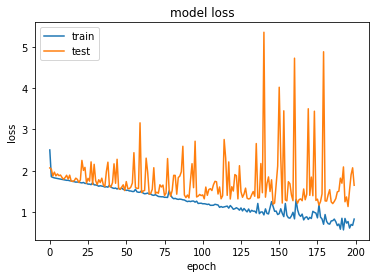

In [121]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
cv_kfold = StratifiedKFold(n_splits=5, shuffle=True)

models = []
X = X_train
X_extra = X_train2
y = y_train
test   = {"text": X_val, "extra": X_val2}

y_test = y_val

for train_index, test_index in cv_kfold.split(X, y):
  model = build_model()
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      #optimizer=tf.keras.optimizers.Adam(learning_rate=0.007, amsgrad=True),
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.4, nesterov=True),
      metrics=["accuracy"]
  )
  input_train = {"text": X[train_index], "extra": X_extra[train_index]}
  input_val   = {"text": X[test_index], "extra": X_extra[test_index]}
  y_train = y[train_index]
  y_val = y[test_index]
  f1_callback1 = ROCCallback(validation = (input_val, y_val), verbose = 0)                                   
  best_callback1 = ReturnBestEarlyStopping(monitor="val_f1",
                                          min_delta=0,
                                          patience=200,
                                          verbose=0,
                                          mode="max",
                                          #baseline=0.72,
                                          restore_best_weights=True)
  model.fit(input_train, y_train, batch_size=128, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback1, best_callback1], verbose=0)
  y_test_pred = np.where(model.predict(test) >0.5,1,0)
  print(f1_score(y_test,y_test_pred,average="macro"))
  models.append(model)


0.7020388105758069
0.7397104473272389
0.7321598940789346
0.7251979246114018
0.7258058638290028


In [ ]:
def ensemble_predictions(members, testX):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(test) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [ ]:
y_pred = ensemble_predictions(models, test)
print(classification_report(y_test,y_pred))


(5, 684)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       370
           1       0.67      0.70      0.68       314

    accuracy                           0.70       684
   macro avg       0.70      0.70      0.70       684
weighted avg       0.70      0.70      0.70       684

